In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
ratings_df = pd.read_csv("dataBig/ratings.csv").drop("timestamp", axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'dataBig/ratings.csv'

In [3]:
ratings_df =  ratings_df.sample(frac=1, random_state=420).reset_index(drop=True)
ratings_df

,userId,movieId,rating
0,254775,6870,3.5
1,123364,2571,4.5
2,311036,165699,2.5
3,14961,509,3.0
4,73223,1200,4.0
...,...,...,...
33832157,18606,457,4.0
33832158,25653,96020,5.0
33832159,56721,1682,5.0
33832160,181122,592,3.0


In [4]:
print(len(ratings_df["userId"].unique()))
len(ratings_df["movieId"].unique())

330975


83239

In [5]:
test_ratings_df = ratings_df.sample(int(len(ratings_df)*0.1), random_state=420)
sampled_indices = test_ratings_df.index

test_pairs =  test_ratings_df[["userId", "movieId"]]
actual_ratings = test_ratings_df["rating"]
remaining_df = ratings_df.drop(sampled_indices)

del ratings_df
del sampled_indices

In [6]:
# Removing rarly scored movies
movie_counts = remaining_df['movieId'].value_counts()
rare_movies = movie_counts[movie_counts < 5].index
remaining_df = remaining_df[~remaining_df['movieId'].isin(rare_movies)]
del rare_movies

In [7]:
remaining_df = remaining_df[remaining_df["rating"] >= 4 ]

In [8]:
# remaining_df = remaining_df.iloc[:1000]
movies = remaining_df["movieId"].unique()
users = remaining_df["userId"].unique()

In [9]:
from sklearn.cluster import MiniBatchKMeans, KMeans
# import warnings
# # warnings.filterwarnings('ignore')

In [10]:
%timeit
kmeans = MiniBatchKMeans(n_clusters=11,
                         random_state=420,
                         n_init="auto")
          
number_of_batches = 49


for iteration, users_batch in enumerate(np.array_split(users, number_of_batches)):
    print(f"Iteration {iteration}")
    
    ratings = remaining_df.loc[remaining_df["userId"].isin(users_batch)]
#     print(ratings)
    X = pd.pivot_table(ratings, index=["userId"], columns="movieId").fillna(False).astype(bool)
    X.columns = X.columns.get_level_values(1)
    X = X.reindex(columns = movies, fill_value=False)

    kmeans.partial_fit(X)
# 
    

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48


<Axes: xlabel='cluster', ylabel='count'>

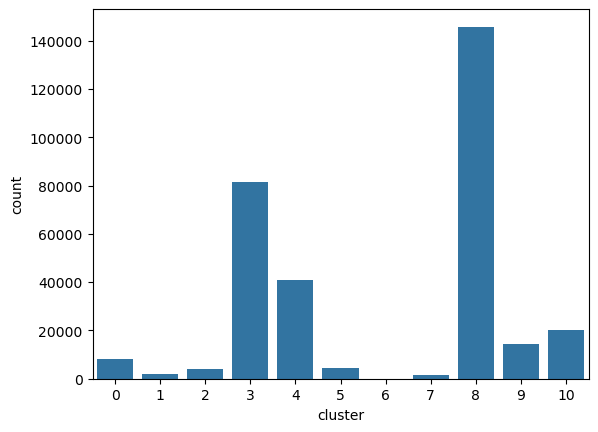

In [11]:
%timeit

user_clusters = pd.DataFrame({"userId": users, "cluster": 99}).set_index("userId")
user_clusters

x=0
for iteration, users_batch in enumerate(np.array_split(users, number_of_batches)):
    print(f"Iteration {iteration}")
    
    ratings = remaining_df.loc[remaining_df["userId"].isin(users_batch)]
    X = pd.pivot_table(ratings, index="userId", columns="movieId").fillna(False).astype(bool)
    X.columns = X.columns.get_level_values(1)
    X = X.reindex(columns = movies, fill_value=False)
    
    batch_clusters = kmeans.predict(X)
    for i, user_id in enumerate(users_batch):
        user_clusters.loc[user_id, "cluster"] = batch_clusters[i]

sns.countplot(data = user_clusters, x = "cluster")

<Axes: xlabel='cluster', ylabel='count'>

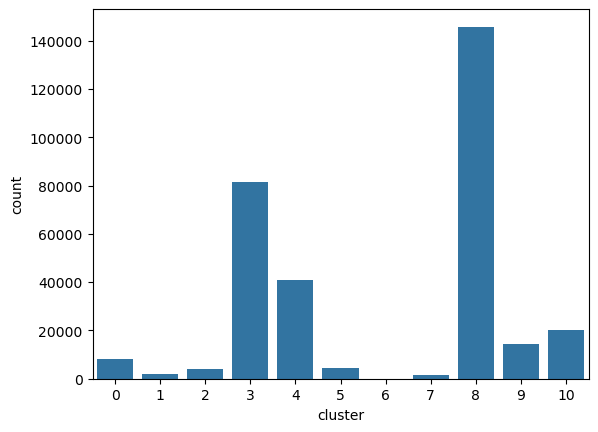

In [12]:
sns.countplot(data = user_clusters, x = "cluster")

In [15]:
remaining_df = pd.merge(remaining_df, user_clusters, how="left", on="userId")

In [25]:
cluster_ratings = remaining_df.drop("userId", axis=1).groupby(["cluster", "movieId"]).mean()


In [29]:
%timeit

from sklearn.metrics import mean_squared_error

users_not_in_training = 0
movies_not_watched_in_cluster = 0
movie_not_in_training = 0

average_ranking = remaining_df["rating"].mean()
def predict(user_id, movie_id):
    global users_not_in_training, movies_not_watched_in_cluster, movie_not_in_training

    if user_id not in user_clusters.index:
        users_not_in_training += 1
        return average_ranking
    
    cluster = int(user_clusters.loc[user_id, "cluster"])
    
    try:
        rating = cluster_ratings.loc[(cluster, movie_id), "rating"]
        
    except KeyError:
        rating = remaining_df.loc[remaining_df["movieId"] == movie_id]["rating"].mean()
        if np.isnan(rating):
            movie_not_in_training += 1
            return average_ranking
        else:
            movies_not_watched_in_cluster += 1
            return rating

        
    return rating
    
y_predicted = np.array([predict(user_id, movie_id) for user_id, movie_id in zip(test_pairs["userId"] ,test_pairs["movieId"])])
total = len(y_predicted)

print(users_not_in_training/total)
print(movies_not_watched_in_cluster/total)
print(movie_not_in_training/total)

y_predicted
    
mean_squared_error(y_predicted, actual_ratings)


0.0018902133354772501
0.006193219705747431
0.0038221029931284315


1.744208121792502

In [39]:
just_fucking_averages = pd.read_csv("dataBig/ratings.csv").drop(["timestamp", "userId"], axis=1).groupby("movieId").mean()
y_predicted = np.array([predict(user_id, movie_id) for user_id, movie_id in zip(test_pairs["userId"] ,test_pairs["movieId"])])



,rating
movieId,
1,3.893508
2,3.278179
3,3.171271
4,2.868395
5,3.076957
...,...
288967,3.500000
288971,0.500000
288975,4.000000


In [45]:
%%time
def alternative_predictor(user_id, movie_id):
    return just_fucking_averages.at[movie_id, "rating"]


y_predicted = np.array([alternative_predictor(user_id, movie_id) for user_id, movie_id in zip(test_pairs["userId"] ,test_pairs["movieId"])])
    
mean_squared_error(y_predicted, actual_ratings)

CPU times: user 13.6 s, sys: 125 ms, total: 13.7 s
Wall time: 13.8 s


0.925742050126255

In [46]:
#Zabije sie